# Proyecto final 
## Modelo 2 - Segmentación
### Programación de Inteligencia Artificial
### Redes neuronales con imágenes
# Juan Antonio Donet
[Github](https://github.com/hechix/Clasificar-y-segmentar-radiografias)

# Contexto

El proyecto consiste en 3 partes:

- 1. Clasificador,Crear una red neuronal que distinga entre radiografías de pacientes, tomadas de frente o desde el lateral, y clasificarlas según si son frontales o laterales.
- 2. Segmentador, (Este notebook) Crear una red neuronal tomando la radiografía frontal, segmente los pulmones.
- 3. Clasificar y segmentar, Crear un pequeño programa que al pasarle una radiografía, haga lo siguiente:
    - 1. Usar Clasificador para clasificar como frontal o lateral, en caso de no ser frontal, dar un error.
    - 2. Usar Segmentador para segmentar los pulmones.

# Estrategia

- 1. Crear un modelo base, y ver su rendimiento.
- 2. Intentar modificar el modelo base para que sea más eficiente y tenga menos tasa de error.
- 3. Seleccionar el modelo que mejor se adapte a los datos.

# 0. Importes, carga y preparación de datos

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random as rnd
import json

In [2]:
IMG_LADO = 128
LOTE = 8
CMAP_IMAGEN = 'bone'
CMAP_MASCARA = 'gray'
CMAP_PREDICCION ='coolwarm'

Carga la imágen en escala de grises de 0 a 1, con tamaño IMG_LADO x IMG_LADO.

In [3]:
def cargar_img(ruta):
    img = cv2.imread(ruta)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_LADO, IMG_LADO))
    img = img.astype(np.float32)
    img = img / 255.0
    return img

Genera 2 listas:
- imgs: las imágenes procesadas por cargar_imágen, cada imagen se copia y se inserta volteada sobre el eje x, teniendo 2 imágenes por cada imagen original.
- msks: las imágenes de las mascaras, cada imagen se copia y se inserta volteada sobre el eje x, teniendo 2 imágenes por cada imagen original.

Las dos listas se aleatorizan, sin perder la relacion entre ellas.

In [4]:
def generar_dataset(ruta):
    rnd.seed(10)
    imgs = []
    msks = []
    imgs_dire = os.listdir(ruta + 'images/')
    msks_dire = os.listdir(ruta + 'masks/')
    for n, archivo in enumerate(imgs_dire):
        img = cargar_img(ruta + 'images/' + archivo)
        volteado_horizontal = np.flip(img, 1)
        imgs.append(img)
        imgs.append(volteado_horizontal)

        mascara = cargar_img(ruta + 'masks/' + msks_dire[n])
        volteado_horizontal = np.flip(mascara, 1)
        msks.append(mascara)
        msks.append(volteado_horizontal)

    for i in range(len(imgs)):
        n = rnd.randint(i, len(imgs) - 1)
        imgs[n], imgs[i] = imgs[i], imgs[n]
        msks[n], msks[i] = msks[i], msks[n]

    return np.array(imgs), np.array(msks)

Generar datasets y comprobar su tamaño.

In [5]:
x_train, y_train = generar_dataset('lung_segmentation/train/')
x_vali, y_vali = generar_dataset('lung_segmentation/validation/')
x_test, y_test = generar_dataset('lung_segmentation/test/')

In [159]:
print('Train:', x_train.shape[0], y_train.shape[0])
print('Validation:', x_vali.shape[0], y_vali.shape[0])
print('Test:', x_test.shape[0], y_test.shape[0])

Train: 4000 4000
Validation: 638 638
Test: 638 638


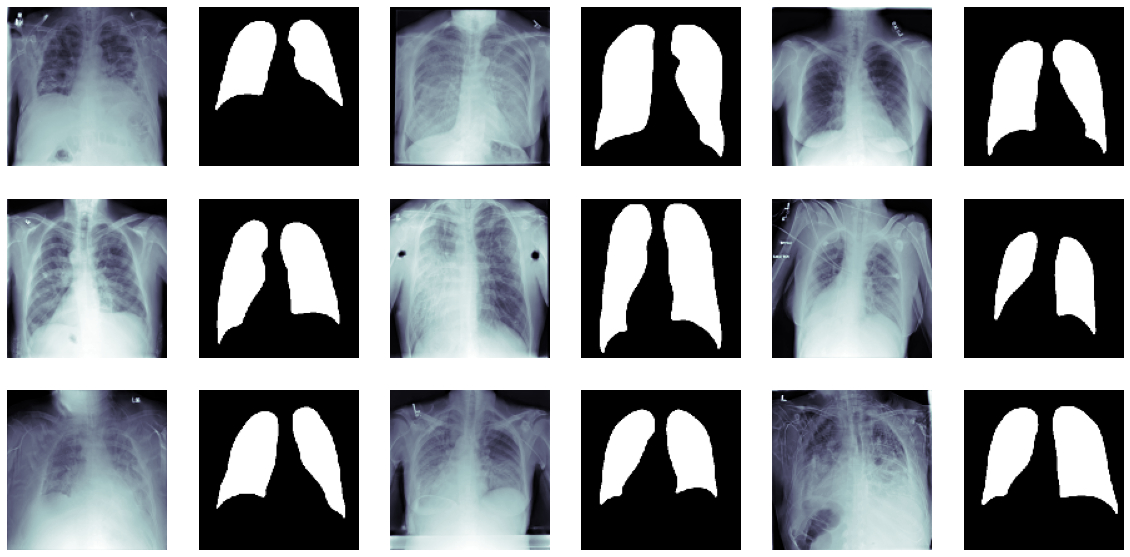

In [160]:
figura = plt.figure(figsize=(20,10))
i = 0
for n in range(9):
    i+=1 
    hueco = figura.add_subplot(3, 6, i)
    hueco.imshow(x_train[n], cmap=CMAP_IMAGEN)
    hueco.axis('off')

    i+=1 
    hueco = figura.add_subplot(3, 6, i)
    hueco.imshow(y_train[n], cmap=CMAP_MASCARA)
    hueco.axis('off')

# 1. Creación de los modelos

## 1.0. Función para automatizar entrenamiento y visualización de resultados

Si el modelo ya existe en el disco, lo carga.

Si no existe, lo entrena y lo guarda en disco.

Crea el gráfico de pérdidas y validación, con la matriz de confusión de positivos y negativos. Lo hace en función de si la salida es >= 0.5 es positivo o sino, negativo.

In [6]:
def entrenar_y_guardar_modelo(modelo, nombre):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'modelos/{nombre}.h5',
        monitor='binary_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0)

    modelo.fit(x_train, y_train, epochs=10, validation_data=(x_vali, y_vali), callbacks=[model_checkpoint_callback], verbose= 1, batch_size=LOTE)
    historial = modelo.history.history
    evaluacion = modelo.evaluate(x_test, y_test, verbose=0)

    guardar_modelo(historial, evaluacion, nombre)
    
    return modelo, historial, evaluacion

def guardar_modelo(historial, evaluacion, nombre):    
    open('modelos/' + nombre + '_historial.json', 'w').write(json.dumps(historial))
    open('modelos/' + nombre + '_evaluacion.json', 'w').write(json.dumps(evaluacion))
    

def cargar_modelo(modelo, nombre):
    modelo.load_weights('modelos/' + nombre + '.h5')
    historial = json.loads(open('modelos/' + nombre + '_historial.json').read())
    evaluacion = json.loads(open('modelos/' + nombre + '_evaluacion.json').read())

    return modelo, historial, evaluacion

def dibujar(modelo, historial, evaluacion):
    figura = plt.figure(figsize=(30,10))
    hueco = figura.add_subplot(1,3,1)
    hueco.plot(historial['loss'], 'b--',label='Entrenamiento')
    hueco.plot(historial['val_loss'], 'g-', label='Validación')
    hueco.plot(list(range(len(historial['loss']))), [evaluacion[0] for _ in historial['loss']], 'r-', label='Evaluación')
    hueco.set_title(f'Pérdida {evaluacion[0]:.4f}')
    hueco.set_ylabel('Perdida')
    hueco.set_xlabel('Epocas')
    hueco.legend()

    hueco = figura.add_subplot(1,3,2)
    hueco.plot(historial['binary_accuracy'], 'b--', label='Entrenamiento')
    hueco.plot(historial['val_binary_accuracy'],'g-', label='Validación')
    hueco.plot(list(range(len(historial['binary_accuracy']))), [evaluacion[1] for _ in historial['binary_accuracy']], 'r-', label='Evaluación')
    hueco.set_title(f'Precisión {evaluacion[1]:.4f}')
    hueco.set_ylabel('Precisión')
    hueco.set_xlabel('Epocas')
    hueco.legend()

    i = 0
    for n in range(3):
        i+=1 
        hueco = figura.add_subplot(3, 9, i + 6)
        hueco.imshow(x_test[n], cmap=CMAP_IMAGEN)
        hueco.axis('off')
        hueco.set_title('Imagen original')

        i+=1 
        hueco = figura.add_subplot(3, 9, i + 6)
        hueco.imshow(y_test[n], cmap=CMAP_MASCARA)
        hueco.axis('off')
        hueco.set_title('Máscara original')

        i+=1 
        prediccion = modelo.predict(np.array([x_test[n]]))[0]        
        hueco = figura.add_subplot(3, 9, i + 6)
        hueco.imshow(prediccion, cmap=CMAP_PREDICCION)
        hueco.axis('off')
        hueco.set_title('Predicción')
        i+= 6

def entrenar_y_visualizar(modelo, nombre):
    if os.path.exists('modelos/' + nombre + '.h5'):
        modelo, historial, evaluacion = cargar_modelo(modelo, nombre)
    else:
        modelo, historial, evaluacion = entrenar_y_guardar_modelo(modelo, nombre)

    dibujar(modelo, historial, evaluacion)

## 1.1. Modelo 1

El primer modelo, o modelo base, voy a definirlo con 4 secciones convolucionales, de 2 capas cada una seguidas por maxpooling, seguido de la misma arquitectura pero creciente, hasta llegar a IMG_LADO * IMG_LADO.

Todas las neuronas serán relu excepto las de salida, que serán sigmoid.

El optimizador será adam, la perdida binary_crossentropy, y la métrica será precisión binaria.

Uso adam porque es el que generalmente usamos, y las funciones binarias ya que es un problema de clasificación binaria de los pixeles.

In [162]:
entrada = tf.keras.Input(shape=(IMG_LADO, IMG_LADO, 1))

# Extraer caracteristicas
# 128 * 16
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(entrada)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# 64 * 32
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# 32 * 64
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Zona intermedia -> El portatil no da pa mas
# 16 * 128
# x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Clasificar pixeles
# 32 * 64
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), (2,2) ,activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# 64 * 32
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), (2,2) , activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# 128 * 16
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), (2,2) , activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# salida
x = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


segmentador_1 = tf.keras.Model(inputs=entrada, outputs=x)
segmentador_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

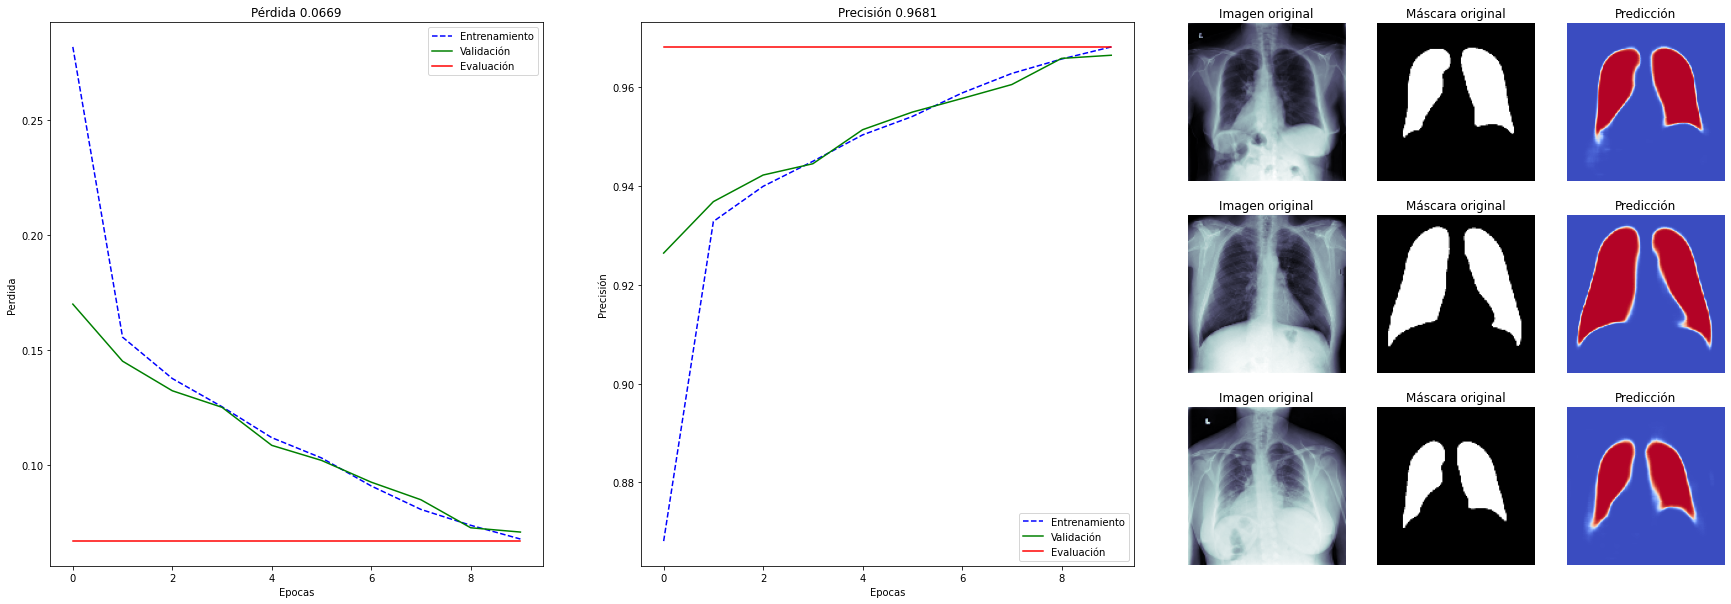

In [163]:
entrenar_y_visualizar(segmentador_1, 'segmentador_1')

La precisión final es 0.9681

## 1.2. Modelo 2

Como el portatil no daba para más en la zona intermedia de 128 convoluciones, voy a entrenar el mismo modelo pero solo hasta 64 convoluciones.

In [164]:
entrada = tf.keras.Input(shape=(IMG_LADO, IMG_LADO, 1))

# Extraer caracteristicas
# 128 * 16
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(entrada)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# 64 * 32
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Zona intermedia
# 32 * 64
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Clasificar pixeles
# 64 * 32
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), (2,2) , activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# 128 * 16
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), (2,2) , activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# salida
x = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


segmentador_2 = tf.keras.Model(inputs=entrada, outputs=x)
segmentador_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

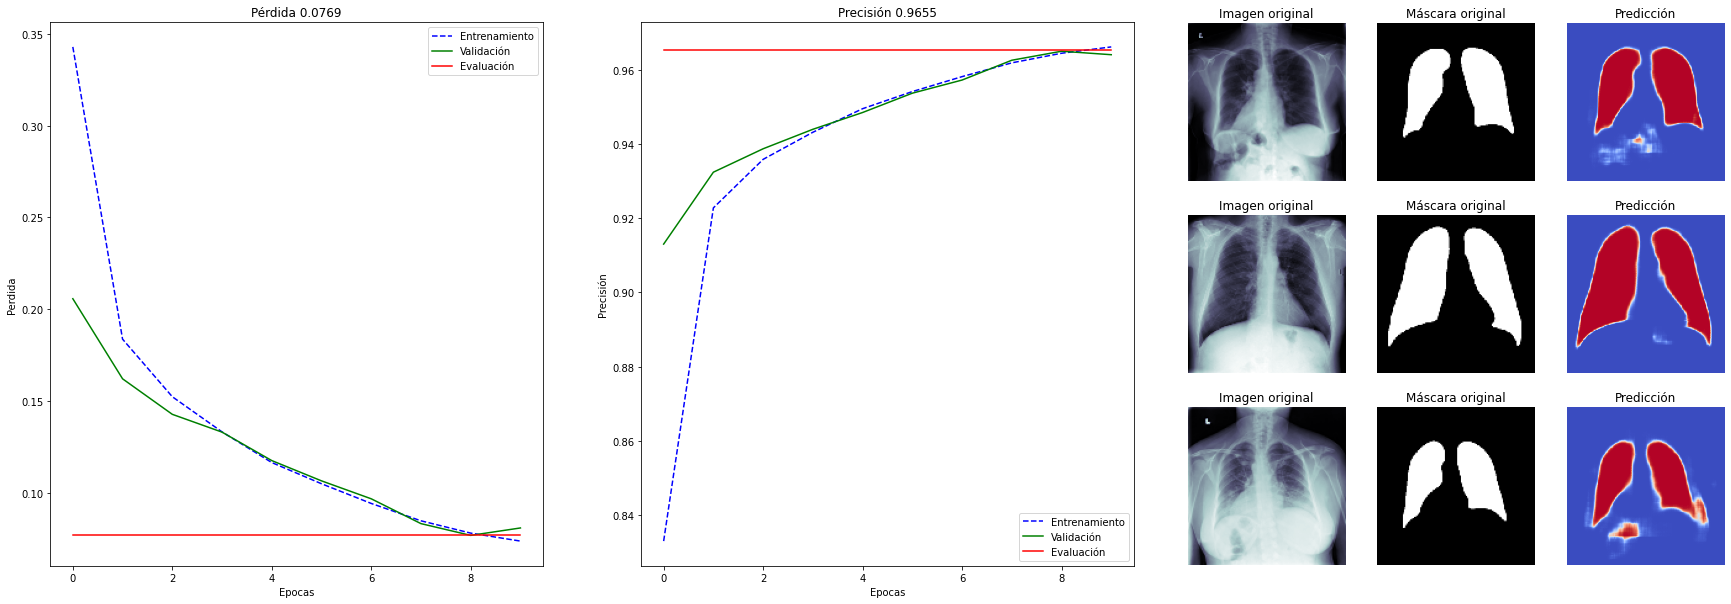

In [166]:
entrenar_y_visualizar(segmentador_2, 'segmentador_2')

La precisión final es 0.9655, no empeora demasiado pero las imágenes salen mas sucias.

## 1.3. Modelo 3

Voy a volver a usar el primer modelo, pero usando rmsprop como optimizador, a ver si en problemas de segmentacion da buen resultado

In [7]:
entrada = tf.keras.Input(shape=(IMG_LADO, IMG_LADO, 1))

# Extraer caracteristicas
# 128 * 16
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(entrada)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# 64 * 32
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# 32 * 64
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Zona intermedia -> El portatil no da pa mas
# 16 * 128
# x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Clasificar pixeles
# 32 * 64
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), (2,2) ,activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# 64 * 32
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), (2,2) , activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# 128 * 16
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), (2,2) , activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

# salida
x = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


segmentador_3 = tf.keras.Model(inputs=entrada, outputs=x)
segmentador_3.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

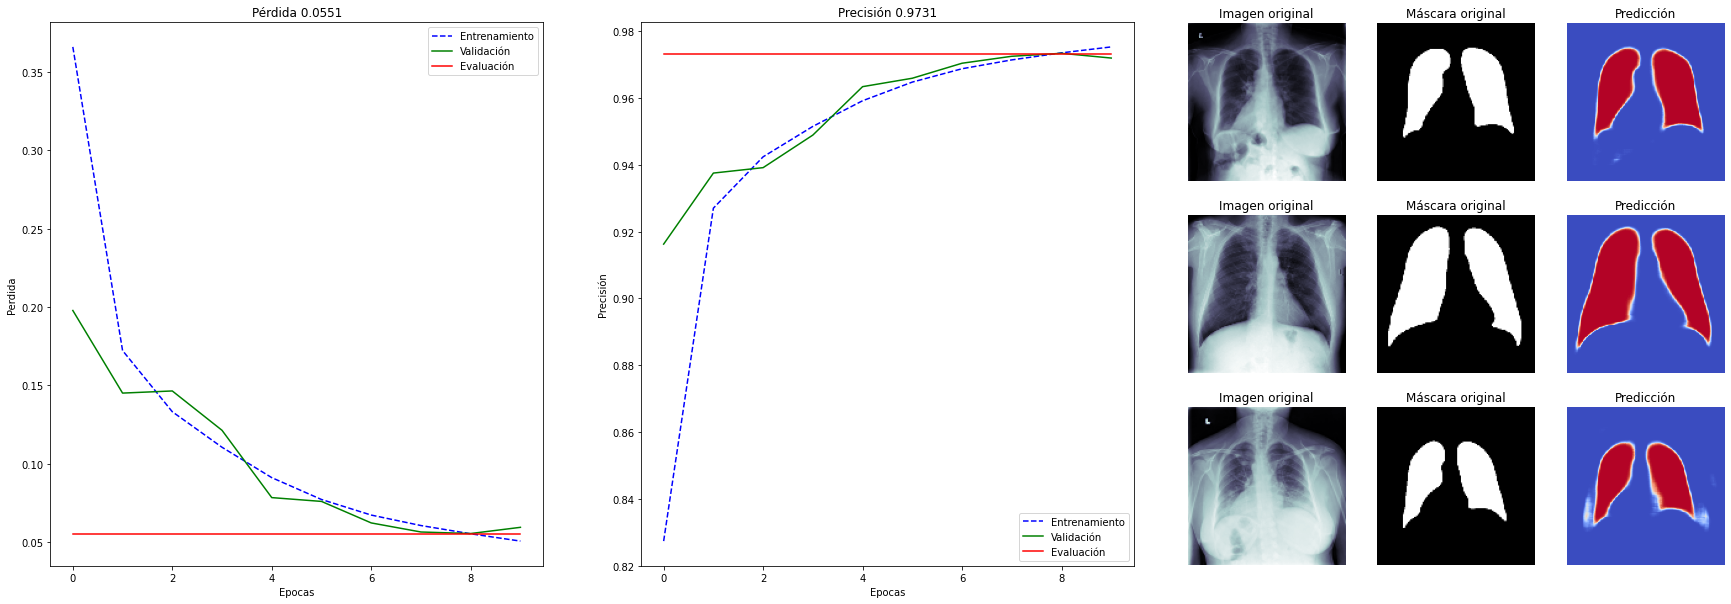

In [9]:
entrenar_y_visualizar(segmentador_3, 'segmentador_3')

La precisión final es 0.9731

# 2. Selección de modelo.

El rendimiento de los modelos ha sido el siguiente:

modelo|optimizador|perdida|precisión test
---|---|---|---	
3|rmsprop|binary_crossentropy|0.9731
1|adam|binary_crossentropy|0.9681
2 (corta)|adam|binary_crossentropy|0.9655

El modelo final es el modelo 3, ya que tiene una precisión muy alta, las imágenes bastante limpias y no creo que vaya a mejorarlo mucho.

Los modelos entrenados se pueden descargar en [Github](https://github.com/hechix/Clasificar-y-segmentar-radiografias)